In [26]:
import momepy
import geopandas as gpd
import matplotlib.pyplot as plt
from libpysal.weights import Queen, Rook, KNN
%matplotlib inline

In [27]:
df = gpd.read_file('parcels_wdev.shp')

In [28]:
df = df.reset_index()[['index', 'geometry']]
df = df.rename(columns={'index': 'ID'})

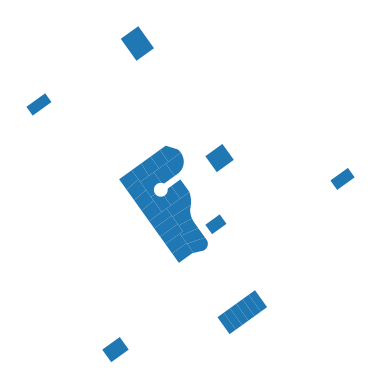

In [29]:
ax = df.plot()
ax.set_axis_off()

In [30]:
crs = df.estimate_utm_crs().to_epsg()
df = df.to_crs(crs)

# preprocess


In [54]:
#df_clean = momepy.preprocess(df, size=30,
#                              compactness=0.3, islands=True, loops=5)

In [55]:
#df_clean.plot()

# limit set at 1

In [31]:
buffer = 1

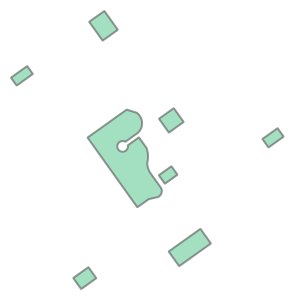

In [32]:
limit = momepy.buffered_limit(df, buffer=buffer)
limit

In [33]:
tessellation = momepy.Tessellation(df, unique_id='ID', limit=limit)

Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


In [34]:
tessellation_gdf = tessellation.tessellation
tessellation_gdf = tessellation_gdf.reset_index(drop=True)

In [37]:
rook = Rook.from_dataframe(tessellation_gdf)

d:\mini-forge\envs\growth_model\Lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 6 islands with ids: 9, 10, 26, 27, 34, 35.
  warnings.warn(message)


In [38]:
all_ids = rook.id_order
islands = rook.islands


In [39]:
# drop from gdf
tessellation_gdf = tessellation_gdf.drop(islands)

In [43]:
tessellation_gdf.to_file(f'tessellation_{buffer}_wdev.shp')

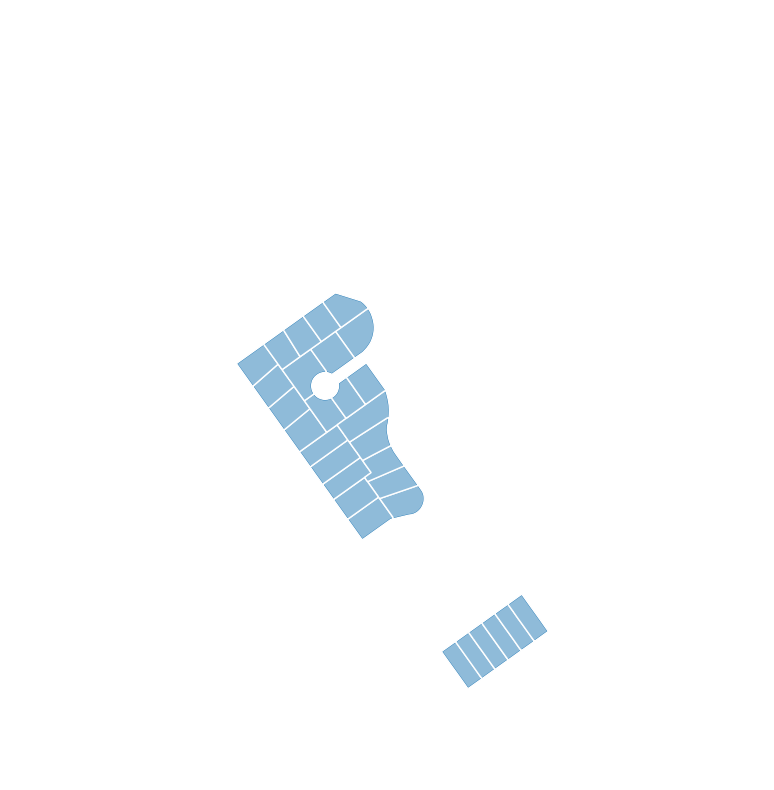

In [40]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation_gdf.plot(ax=ax, edgecolor='white')
df.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()
plt.show()

In [41]:
# remove islands from the list of all ids
all_ids = [x for x in all_ids if x not in islands]



In [42]:
for i in all_ids:
    print(f'ID: {i}: {rook.neighbors[i]}')

ID: 0: [1]
ID: 1: [0, 2]
ID: 2: [1, 3]
ID: 3: [2, 4]
ID: 4: [3, 5]
ID: 5: [4]
ID: 6: [8, 11, 7]
ID: 7: [8, 6]
ID: 8: [11, 20, 6, 7]
ID: 11: [8, 20, 12, 6]
ID: 12: [13, 11, 20, 21]
ID: 13: [12, 21, 22, 14]
ID: 14: [18, 13, 22, 15]
ID: 15: [16, 18, 14]
ID: 16: [17, 18, 28, 15]
ID: 17: [16, 19, 28, 30]
ID: 18: [16, 22, 23, 28, 14, 15]
ID: 19: [17, 30]
ID: 20: [8, 11, 12, 21]
ID: 21: [13, 20, 12, 22]
ID: 22: [18, 21, 23, 24, 13, 14]
ID: 23: [24, 18, 22]
ID: 24: [22, 23]
ID: 25: [32, 33, 29]
ID: 28: [16, 17, 18, 29, 30, 31]
ID: 29: [32, 25, 28, 31]
ID: 30: [17, 19, 28, 31]
ID: 31: [32, 28, 29, 30]
ID: 32: [33, 29, 25, 31]
ID: 33: [32, 25]
